# Using flax for MNIST Handwritten Digit Classification

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FlorianMarquardt/machine-learning-for-physicists/blob/master/2024/04_tutorial_MNIST.ipynb)

Tutorial code for the lecture series "Machine Learning for Physicists" by Florian Marquardt

See https://machine-learning-for-physicists.org and the current course website linked there!

This notebook shows how to build a dense neural network  and convolutional neural network (CNN) using flax to do the classification task with MNIST handwritten digit dataset.

First version by Remmy Zen 2024. MIT License.

In [1]:
import jax.numpy as jnp
from jax import grad, value_and_grad, jit, vmap
import jax
import tensorflow as tf
import numpy as np
from flax import linen as nn # the neural-network library from flax
import optax # for optimization
from matplotlib import pyplot as plt # plotting
%config InlineBackend.figure_format='retina'

## Loading the MNIST dataset

In [2]:
## Load mnist dataset using tensorflow
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

## Normalize input to be between 0 and 1
x_train = x_train / 255.
x_test = x_test / 255.

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


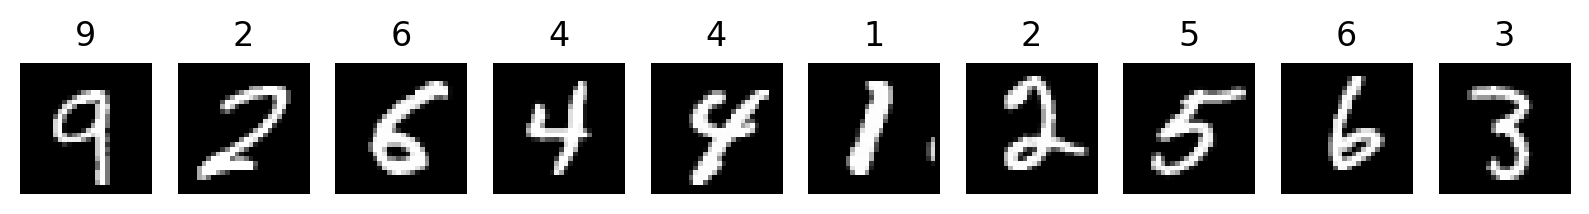

In [3]:
## Visualize some of the data
num_images = 10

## Choose random index of the data
random_index = np.random.choice(range(60000), size=(num_images,), replace=False) ## replace = false for unique data

plt.figure(figsize=(num_images, 1))
for i, index in enumerate(random_index):
    plt.subplot(1, num_images, i+1)
    plt.imshow(x_train[index], cmap='gray')
    plt.title(y_train[index])
    plt.axis('off')
plt.show()

## MNIST Classification with dense neural network

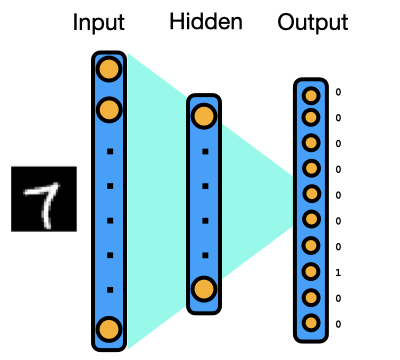


In [101]:
# define a simple dense neural network  using flax
class DenseNetwork(nn.Module):
  hidden_neurons: int # a parameter we can choose during initialization
  hidden_neurons2: int
  output_neurons: int

  ########################
  ## EXERCISE 1:
  ## What do we need to change to the __call__ function for classification task?
  ########################
  @nn.compact
  def __call__(self,x):
    # note: number of input neurons will be defined
    # by the shape of x when calling the network for the first time!
    x = nn.Dense(features=self.hidden_neurons)(x) # neurons for  hidden layer
    x = nn.relu(x) # relu activation
    x = nn.Dense(features=self.hidden_neurons2)(x) # neurons for output
    x = nn.sigmoid(x) # sigmoid activation
    x = nn.Dense(features=self.output_neurons)(x) # neurons for output
    x = nn.softmax(x) # sigmoid activation
    return x


In [103]:
# actually produce the network, with randomly initialized parameters

network = DenseNetwork(hidden_neurons=300, hidden_neurons2=100, output_neurons=10) # get an instance of the "Network" class
x = jnp.zeros((28*28,)) # dummy input for initialization
random_key = jax.random.key(42) # get a random key
params = network.init(random_key, x) # randomly initialize parameters

# call to network.apply, which applies the network
# to x, given the parameters params:
network.apply(params, x)

Array([0.11155203, 0.07294002, 0.04301469, 0.07345428, 0.07551937,
       0.07849832, 0.06761856, 0.20699576, 0.12596606, 0.14444086],      dtype=float32)

In [104]:
# Have a look at the way the parameters are stored:
# inside a dictionary! 'kernel' means the weight matrix!
params

{'params': {'Dense_0': {'kernel': Array([[-1.8643843e-02, -4.5388930e-02,  4.5484487e-02, ...,
            7.0052341e-02,  9.9589082e-04, -2.5842551e-02],
          [ 4.5139726e-02,  3.2606084e-02, -1.9246705e-02, ...,
            1.5312453e-02, -7.1193196e-02, -1.3498645e-02],
          [ 2.9713208e-02,  1.2297222e-02, -6.2184572e-02, ...,
           -2.3842720e-02, -4.4661649e-02, -4.6051245e-02],
          ...,
          [-2.9733988e-02, -3.9541856e-03, -3.8308326e-02, ...,
            1.4384081e-02, -4.3098368e-02,  2.3746030e-02],
          [ 5.9870098e-02, -7.4649997e-02, -6.0925907e-03, ...,
            3.9374713e-02, -2.7319670e-03, -4.3379139e-05],
          [-3.2417394e-02,  5.8020096e-02, -3.6046479e-02, ...,
           -2.4672715e-02,  4.5456309e-03,  4.1646067e-02]], dtype=float32),
   'bias': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0.,

In [105]:
## Size of the hidden layer
params['params']['Dense_0']['kernel'].shape, params['params']['Dense_1']['kernel'].shape,params['params']['Dense_2']['kernel'].shape

((784, 300), (300, 100), (100, 10))

### Compiling and batch processing

In [187]:
########################
## EXERCISE 2:
## Implement the categorical cross entropy loss function
## loss = - \sum y_target * \log y_out
########################
# define a cost function, for classification: categorical cross entropy
def cost(params,x,y_target):
  ### NOTE: Remember that this is a batched function
  ### so x size is [batch_size, 784] and y_target size is [batch_size, 1]
  ### 1. Get y_out by applying network and params
  y_out = network.apply(params, x)
  ### 2. Get the one hot labels of the y_target
  one_hot_labels = jax.nn.one_hot(y_target, num_classes=10)

  ### 3. Calculate \sum y_target * \log y_out
  ### (take note of the axis when summing because of the batches)
  loss = -jnp.sum(one_hot_labels * jnp.log(y_out))
  ### 4. Take the mean of the loss across the batches
  return jnp.average(loss)

In [107]:
# batches: vmap does the trick!
batched_cost=vmap(cost,in_axes=(None,0,0))

In [108]:
# want to average the cost over the batch:
def average_cost(params,x,y_target):
  return jnp.average(batched_cost(params,x,y_target))

In [109]:
# compiled version of gradient of cost function, which
# returns both the value and the gradient:
batched_value_and_grad_cost=jit(value_and_grad(average_cost))

### Training using optax

#### Preparation of the optax 'optimizer'

In [116]:
# choose and prepare the optimizer
learning_rate=0.01
optimizer=optax.adam(learning_rate) # choose type of optimizer
opt_state=optimizer.init(params) # initialize the state of the optimizer

#### Running the training loop

In [186]:
# now you can run a training loop:
num_batches=1000
batch_size=64
cost_history=[]

for train_step in range(num_batches):
  # producing the random batch
  # first, a new random key:
  random_key,new_key=jax.random.split(random_key)
  # produce a new batch (inputs x, desired outputs y):
  random_index = jax.random.choice(new_key, jnp.array(range(x_train.shape[0])), shape=(batch_size,), replace = False) ## replace = false for unique data

  x = jnp.array(x_train[random_index].reshape((batch_size, -1)))
  y = jnp.array(y_train[random_index])

  # get gradients and the current value of the cost function
  cost,grads = batched_value_and_grad_cost(params,x,y)

  # the optax part: calculate the updates and apply them to change 'params':
  updates, opt_state = optimizer.update(grads, opt_state)
  params = optax.apply_updates(params, updates)

  cost_history.append(cost)

ScopeParamShapeError: Initializer expected to generate shape (4, 4, 1, 20) but got shape (4, 4, 784, 20) instead for parameter "kernel" in "/Conv_0". (https://flax.readthedocs.io/en/latest/api_reference/flax.errors.html#flax.errors.ScopeParamShapeError)

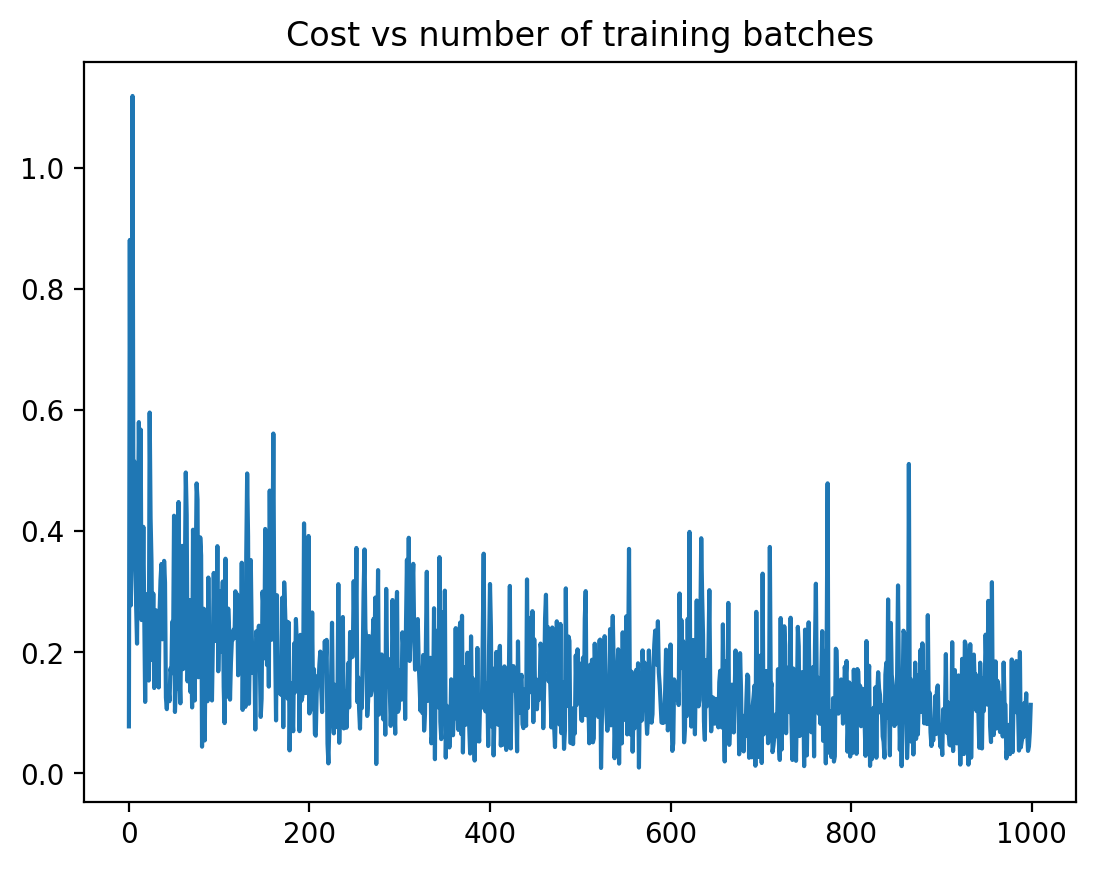

In [118]:
plt.plot(cost_history)
plt.title("Cost vs number of training batches")
plt.show()

### Evaluation

In [119]:
## Get the accuracy with the test data
x = x_test.reshape((x_test.shape[0], -1))
result = jnp.argmax(network.apply(params,x), axis=-1)

print('Testing accuracy:', jnp.mean(result == y_test))

Testing accuracy: 0.96089995


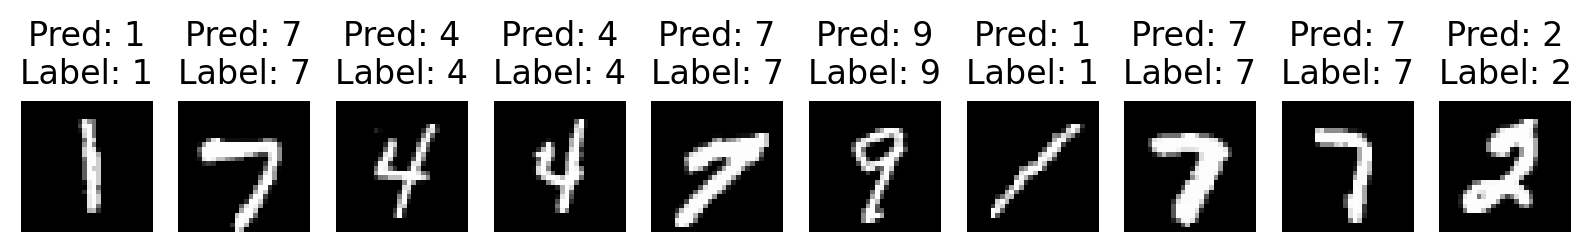

In [120]:
## Visualize some of the data
num_images = 10

random_key,new_key=jax.random.split(random_key)
# produce a new batch (inputs x, desired outputs y):
random_index = jax.random.choice(new_key,jnp.array(range(x_test.shape[0])), shape=(num_images,), replace = False) ## replace = false for unique data
plt.figure(figsize=(num_images, 1))
for i, index in enumerate(random_index):
    plt.subplot(1, num_images, i+1)
    plt.imshow(x_test[index], cmap='gray')
    plt.title('Pred: %d\nLabel: %d' % (result[index], y_test[index]))
    plt.axis('off')
plt.show()

In [ ]:
########################
## EXERCISE 3:
## Try to play around with the parameters and see how it affect the training progress
## Try to change the number of hidden neurons, add more hidden layer, learning rate, batch_size, etc.
## Try to get a higher accuracy.
########################

## MNIST Classification with convolutional neural network

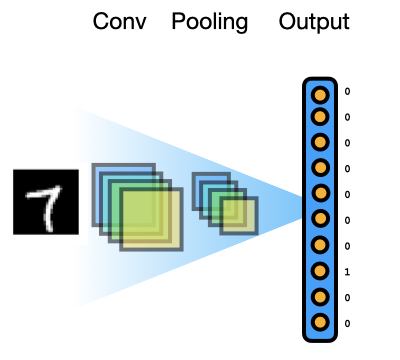

In [149]:
# define a simple conv neural network using flax
class ConvNetwork(nn.Module):
  conv_features: int
  output_neurons: int

  @nn.compact
  def __call__(self, x):
      x = nn.Conv(features=self.conv_features, kernel_size=(4, 4))(x)  # Convolutional layer
      x = nn.relu(x)
      x = nn.Conv(features=self.conv_features, kernel_size=(3, 3))(x)  # Convolutional layer
      x = nn.sigmoid(x)
      x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))  # Pooling layer
      x = x.reshape((x.shape[0], -1))  # Flatten
      x = nn.Dense(features=self.output_neurons)(x)
      x = nn.softmax(x)  # Use log softmax for better numerical stability
      return x

In [150]:
# actually produce the network, with randomly initialized parameters
network = ConvNetwork(conv_features=20, output_neurons=10) # get an instance of the "Network" class
x = jnp.zeros((1,28,28,1)) # dummy input for initialization
random_key = jax.random.key(42) # get a random key
params = network.init(random_key, x) # randomly initialize parameters

# call to network.apply, which applies the network
# to x, given the parameters params:
network.apply(params, x)

Array([[0.10168149, 0.06551739, 0.12618932, 0.11795449, 0.06974671,
        0.188892  , 0.0408042 , 0.05787613, 0.13349466, 0.09784368]],      dtype=float32)

In [141]:
# Have a look at the way the parameters are stored:
# inside a dictionary! 'kernel' means the weight matrix!
params

{'params': {'Conv_0': {'kernel': Array([[[[-0.14592375,  0.4096746 , -0.10273966,  0.5451607 ,
             -0.30535388,  0.13827406,  0.12171839, -0.34430444,
             -0.32906476, -0.31635582, -0.36602795,  0.36257476,
              0.48505923,  0.02078914,  0.5363445 ,  0.5399542 ,
             -0.1662284 , -0.00471987,  0.2547377 ,  0.09314701]],
   
           [[-0.30308276,  0.5367923 ,  0.20731159,  0.09175916,
              0.2820755 ,  0.59517366,  0.56286156,  0.34468463,
             -0.24633268,  0.01485515, -0.20488255, -0.1414035 ,
             -0.04899631,  0.40913758, -0.26533675, -0.14116657,
              0.6489873 , -0.06959984,  0.16989468, -0.23118898]],
   
           [[-0.34221125, -0.6306478 ,  0.09517214, -0.5337677 ,
              0.1497673 , -0.55216557, -0.2448586 , -0.03866476,
             -0.12779686, -0.17688729,  0.16291443, -0.74551624,
             -0.20982786, -0.3773972 , -0.4315888 , -0.5545162 ,
              0.57601005,  0.5010953 ,  0.564348

In [142]:
## Shape of the conv layer (kernel_size, kernel_size, dimension, conv_features)
params['params']['Conv_0']['kernel'].shape

(3, 3, 1, 20)

### Compiling and batch processing

Nothing changes here for CNN

In [143]:
# batches: vmap does the trick!
batched_cost=vmap(cost,in_axes=(None,0,0))

TypeError: Expected a callable value, got 0.09320249408483505

In [133]:
# compiled version of gradient of cost function, which
# returns both the value and the gradient:
batched_value_and_grad_cost=jit(value_and_grad(average_cost))

### Training using optax

#### Preparation of the optax 'optimizer'

In [152]:
# choose and prepare the optimizer
learning_rate=0.001
optimizer=optax.adam(learning_rate) # choose type of optimizer
opt_state=optimizer.init(params) # initialize the state of the optimizer

#### Running the training loop

In [153]:
# now you can run a training loop:
num_batches=1000
batch_size=64
cost_history=[]

for train_step in range(num_batches):
  # producing the random batch
  # first, a new random key:
  random_key,new_key=jax.random.split(random_key)
  # produce a new batch (inputs x, desired outputs y):
  random_index = jax.random.choice(new_key, jnp.array(range(x_train.shape[0])), shape=(batch_size,), replace = False) ## replace = false for unique data

  x = jnp.array(x_train[random_index].reshape((batch_size, 1, 28, 28, 1)))
  y = jnp.array(y_train[random_index])

  # get gradients and the current value of the cost function
  cost,grads = batched_value_and_grad_cost(params,x,y)

  # the optax part: calculate the updates and apply them to change 'params':
  updates, opt_state = optimizer.update(grads, opt_state)
  params = optax.apply_updates(params, updates)

  cost_history.append(cost)

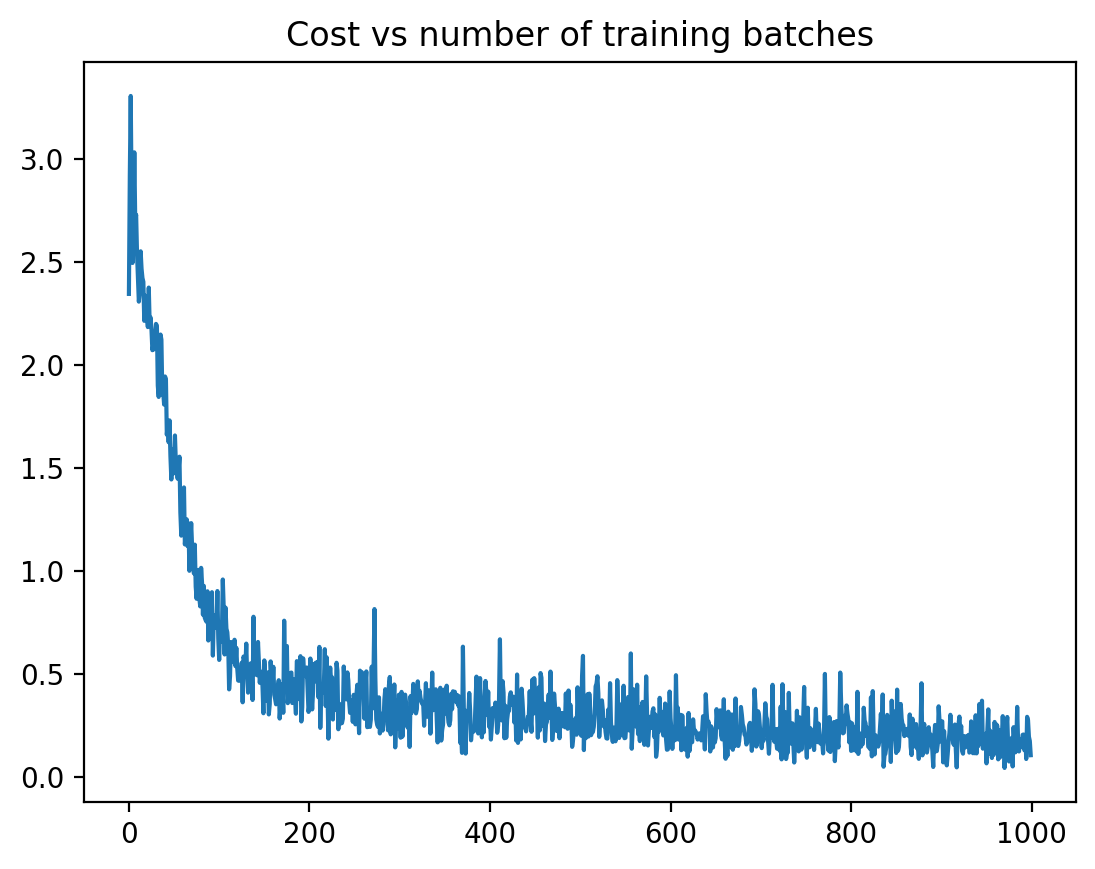

In [154]:
plt.plot(cost_history)
plt.title("Cost vs number of training batches")
plt.show()

### Evaluation

In [155]:
## Get the accuracy with the test data
x = x_test.reshape((x_test.shape[0], 28, 28, 1))
result = jnp.argmax(network.apply(params,x), axis=-1)

print('Testing accuracy:', jnp.mean(result == y_test))

Testing accuracy: 0.9544


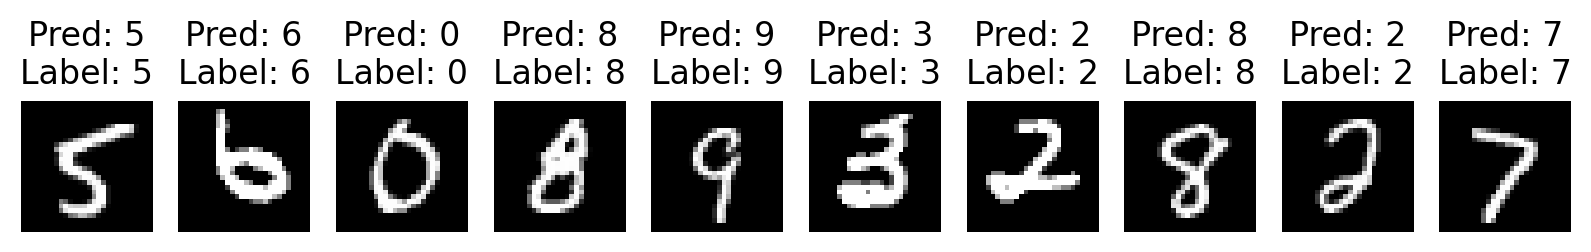

In [158]:
## Visualize some of the data
num_images = 10

random_key,new_key=jax.random.split(random_key)
# produce a new batch (inputs x, desired outputs y):
random_index = jax.random.choice(new_key,jnp.array(range(x_test.shape[0])), shape=(num_images,), replace = False) ## replace = false for unique data
plt.figure(figsize=(num_images, 1))
for i, index in enumerate(random_index):
    plt.subplot(1, num_images, i+1)
    plt.imshow(x_test[index], cmap='gray')
    plt.title('Pred: %d\nLabel: %d' % (result[index], y_test[index]))
    plt.axis('off')
plt.show()

In [ ]:
########################
## EXERCISE 4:
## Try to play around with the parameters and see how it affect the training progress
## Try to change the number of conv_features, add more conv and pooling layer, window_size,
## kernel_size, stride, learning rate, batch_size, etc.
## Try to get a higher accuracy.
########################

## Noisy MNIST Classification with convolutional neural network

In [179]:
## Get the accuracy with a noisy test data
########################
## EXERCISE 5:
## Add a gaussian noise to the data and check how it changes the accuracy.
## Play around with the mean of the Gaussian, does higher noise decrease the classification accuracy?
## Hint: See the np.random.normal function.
########################
gaussian_noise = np.random.normal(0,.5) ## TODO: Implement gaussian noise here
x = x_test + gaussian_noise
x = x.reshape((x_test.shape[0], 28, 28, 1))

result = jnp.argmax(network.apply(params,x), axis=-1)

print('Testing accuracy:', jnp.mean(result == y_test))

Testing accuracy: 0.1074


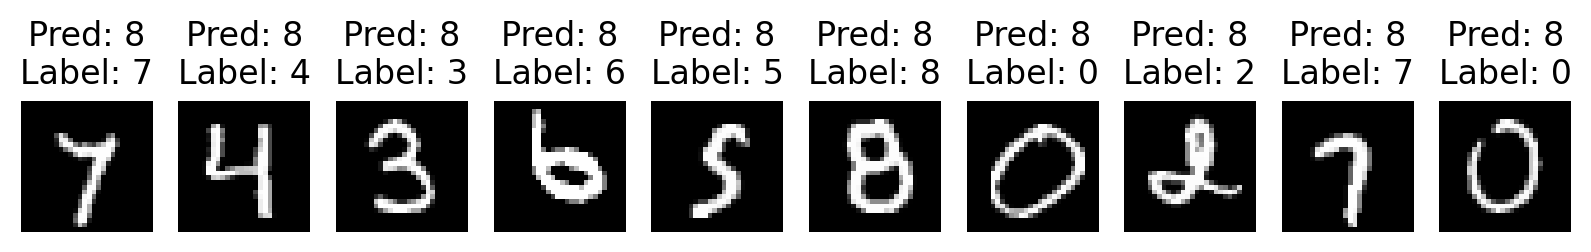

In [169]:
## Visualize some of the data
num_images = 10

random_key,new_key=jax.random.split(random_key)
# produce a new batch (inputs x, desired outputs y):
random_index = jax.random.choice(new_key,jnp.array(range(x.shape[0])), shape=(num_images,), replace = False) ## replace = false for unique data
plt.figure(figsize=(num_images, 1))
for i, index in enumerate(random_index):
    plt.subplot(1, num_images, i+1)
    plt.imshow(x[index], cmap='gray')
    plt.title('Pred: %d\nLabel: %d' % (result[index], y_test[index]))
    plt.axis('off')
plt.show()

In [188]:
## train with noise
batched_cost=vmap(cost,in_axes=(None,0,0))
batched_value_and_grad_cost=jit(value_and_grad(average_cost))

network_noisy = ConvNetwork(conv_features=20, output_neurons=10) # get an instance of the "Network" class
x = jnp.zeros((1,28,28,1)) # dummy input for initialization
random_key = jax.random.key(42) # get a random key
params_noisy = network_noisy.init(random_key, x) # randomly initialize parameters

num_batches=1000
batch_size=32
cost_history=[]

for train_step in range(num_batches):
  # producing the random batch
  # first, a new random key:
  random_key,new_key=jax.random.split(random_key)
  # produce a new batch (inputs x, desired outputs y):
  random_index = jax.random.choice(new_key, jnp.array(range(x_train.shape[0])), shape=(batch_size,), replace = False) ## replace = false for unique data

  ########################
  ## EXERCISE 6:
  ## Let us train neural network with noisy data as well.
  ## Add a random Gaussian noise to the training data during training.
  ## Hint: See the np.random.normal function.
  ########################
  gaussian_noise = np.random.normal(0,.2) ## TODO: Implement gaussian noise here
  x = x_train[random_index] + gaussian_noise
  x = jnp.array(x.reshape((batch_size, 1, 28, 28, 1)))
  y = jnp.array(y_train[random_index])

  # get gradients and the current value of the cost function
  cost,grads = batched_value_and_grad_cost(params_noisy,x,y)

  # the optax part: calculate the updates and apply them to change 'params':
  updates, opt_state = optimizer.update(grads, opt_state)
  params_noisy = optax.apply_updates(params_noisy, updates)

  cost_history.append(cost)

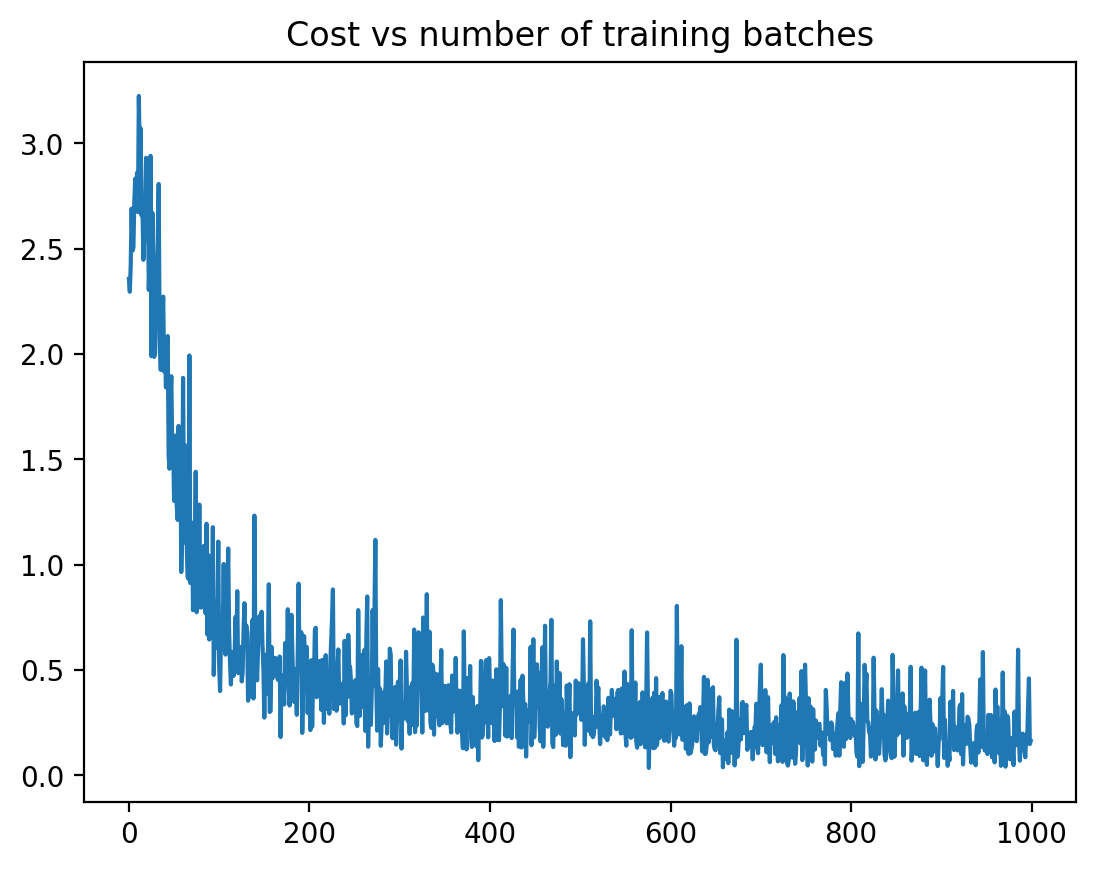

In [189]:
plt.plot(cost_history)
plt.title("Cost vs number of training batches")
plt.show()

In [193]:
## Get the accuracy with a noisy test data
########################
## EXERCISE 7:
## Does training with noisy data helps to improve the accuracy?
########################
gaussian_noise = np.random.normal(0,0) ## TODO: Implement gaussian noise here
x = x_test + gaussian_noise
x = x.reshape((x_test.shape[0], 28, 28, 1))

result = jnp.argmax(network_noisy.apply(params_noisy,x), axis=-1)

print('Testing accuracy:', jnp.mean(result == y_test))

Testing accuracy: 0.95019996


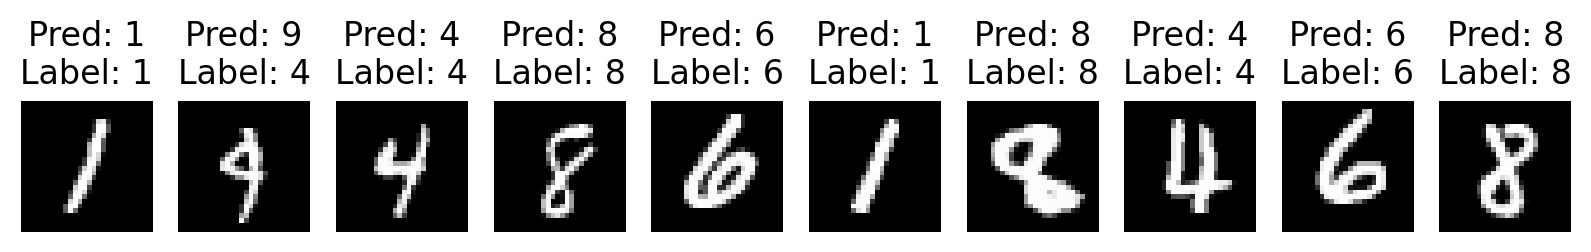

In [185]:
## Visualize some of the data
num_images = 10

random_key,new_key=jax.random.split(random_key)
# produce a new batch (inputs x, desired outputs y):
random_index = jax.random.choice(new_key,jnp.array(range(x.shape[0])), shape=(num_images,), replace = False) ## replace = false for unique data
plt.figure(figsize=(num_images, 1))
for i, index in enumerate(random_index):
    plt.subplot(1, num_images, i+1)
    plt.imshow(x[index], cmap='gray')
    plt.title('Pred: %d\nLabel: %d' % (result[index], y_test[index]))
    plt.axis('off')
plt.show()

In [ ]:
########################
## TAKE HOME EXERCISE:
## 1. Instead of noise, what if you randomly occlude the image?
## 2. In the current training, we do not use any validation data. A good practice
##    in training a neural network is to use Early Stopping that stops the training
##    when validation loss stop decreasing. Try to implement this.
########################